<a href="https://colab.research.google.com/github/djammy/DeepLearning-with-PyTorch/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether something is one thing or another (there can be multiple things as the options).

## 1. First step is always Data. Make classification data and get it ready

In [ ]:
import sklearn
from sklearn.datasets import make_circles

# Make a 1000 samples
n_samples = 1000

# Create circles: X = features, y = labels
X, y = make_circles(n_samples,
                     noise=0.03,
                     random_state=42) # random_state is the equivalent of setting a random seed value

In [ ]:
len(X), len(y)

(1000, 1000)

In [ ]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [ ]:
# Make DataFrame of circle data 
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


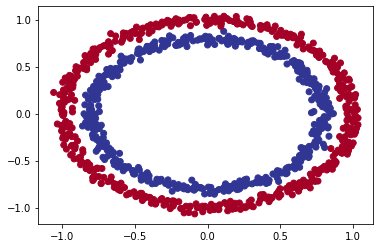

In [ ]:
# Visualize, visualize, visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

Note: the data we are working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enough to practice on

### 1.1 Check input and output shapes

In [ ]:
X.shape, y.shape

((1000, 2), (1000,))

In [ ]:
X # X has a 1000 samples with 2 features

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

### If we are working with PyTorch, we want our dataset to be represented as tensors. Here, when we import from scikit-learn, we are working with numpy arrays

In [ ]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f'Values for one sample of X: {X_sample} and the same for y: {y_sample}')
print(f'Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}')

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


## 1.2 Turn data into tensors and create train and test splits

In [ ]:
# Turn data into tensors
import torch
from torch import nn
torch.__version__

'1.12.1+cu113'

In [ ]:
X.dtype, type(X)

(dtype('float64'), numpy.ndarray)

In [ ]:
# numpy arrays are default float64, however torch tensors are default float32, hence why we have type(torch.float)/type(torch.float32)
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X.dtype, y.dtype

(torch.float32, torch.float32)

In [ ]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [ ]:
type(X), type(y), X.dtype, y.dtype

(torch.Tensor, torch.Tensor, torch.float32, torch.float32)

In [ ]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # test = 20% of data for testing data
                                                    random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Build a model

Let us build a model to classify our blue and red dots.

To do so, we want to:
1. Set up device adnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [ ]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Now we have set up device agnostic code, let us create a model that:

1. Subclass `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [ ]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2,out_features=5) # takes in 2 features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features=5,out_features=1)
  
  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> computation -> layer(2) -> computation -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
device

'cuda'

In [ ]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [ ]:
# Let us replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight', tensor([[ 0.4353,  0.0664],
                      [-0.3889,  0.2932],
                      [ 0.4726,  0.0365],
                      [-0.6459,  0.4642],
                      [-0.2151,  0.2248]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.2431,  0.6950,  0.2376,  0.6852, -0.1791], device='cuda:0')),
             ('1.weight',
              tensor([[-0.1438, -0.0806,  0.3098,  0.0121,  0.2037]], device='cuda:0')),
             ('1.bias', tensor([-0.2969], device='cuda:0'))])

In [ ]:
# Make some predictions
untrained_preds = model_0(X_test.to(device))
print(f'Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}')
print(f'Length of test samples: {len(X_test)}, Shape: {X_test.shape}')
print(f'\nFirst 10 predictions: \n{untrained_preds[:10]}')
print(f'\nFirst 10 labels:\n{y_test[:10]}')

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
tensor([[-0.3462],
        [-0.3132],
        [-0.3965],
        [-0.3321],
        [-0.3389],
        [-0.3192],
        [-0.2719],
        [-0.2732],
        [-0.3988],
        [-0.3103]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1. Set up loss function and optimizer

Which loss function or optimizer
Again... this is problem specific.

For example, for regression, you might want MAE or MSE (mean absolute error or mean squared error)

For classification, you might want binary cross entropy or categorical cross entropy (cross entropy)

As a reminder, the loss function measure how *wrong* your model predictions are.

And for optimizers, two of the most common and useful are SGD, and Adam.

* For some common choices of loss function and optimizer - see book website
* For the loss function we are going to use `torch.nn.BCEWithLogitsLoss()`, for more information on what binary cross entropy (BCE) is, check out this article: https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
* For a definition on what a logit is in deep learning - https://stackoverflow.com/a/52111173
* For different optimizers see `torch.optim`

In [ ]:
# Set up the loss function
#loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCELogitsLoss = sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.1)

In [ ]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right? This is in addition to our loss function
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item() # torch.equal(eq): how many of y_true is equal to the y_pred
  acc = (correct/len(y_pred))*100
  return acc

## 3. Train model

To train our model, we are going to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward
5. Optimizer (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification)

Then we can convert our model's prediction probabilities to prediction labels by either rounding them or taking the `argmax()`.

In [ ]:
# View the first 5 outputs of the forward pass on the test data
# logits are the raw outputs of our model without being passed through an activation model
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.3462],
        [-0.3132],
        [-0.3965],
        [-0.3321],
        [-0.3389]], device='cuda:0')

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [ ]:
# Use the sigmoid activation function on our modellogits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4143],
        [0.4223],
        [0.4022],
        [0.4177],
        [0.4161]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:
* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)

In [ ]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [ ]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

### 3.2 Building a training and testing loop

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
                                              
# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> prod probs -> pred labels

  # 2. Calculate loss/accuracy (don't necessarily have to calculate the accuracy but it is sometimes interesting to have a look at other metrics too)
  loss = loss_fn(y_logits,
                  y_train)
  acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation to calculate gradients)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the test loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_pred)
    
  # Print out what's happening
  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.70773, Acc: 50.00% | Test loss: 0.70751, Test acc: 50.00%
Epoch: 10 | Loss: 0.69760, Acc: 50.00% | Test loss: 0.69899, Test acc: 50.00%
Epoch: 20 | Loss: 0.69451, Acc: 50.00% | Test loss: 0.69656, Test acc: 50.00%
Epoch: 30 | Loss: 0.69356, Acc: 45.25% | Test loss: 0.69591, Test acc: 48.00%
Epoch: 40 | Loss: 0.69326, Acc: 49.00% | Test loss: 0.69574, Test acc: 44.50%
Epoch: 50 | Loss: 0.69315, Acc: 49.75% | Test loss: 0.69570, Test acc: 45.50%
Epoch: 60 | Loss: 0.69311, Acc: 50.38% | Test loss: 0.69568, Test acc: 46.00%
Epoch: 70 | Loss: 0.69309, Acc: 50.38% | Test loss: 0.69566, Test acc: 47.50%
Epoch: 80 | Loss: 0.69307, Acc: 50.38% | Test loss: 0.69564, Test acc: 47.00%
Epoch: 90 | Loss: 0.69306, Acc: 50.25% | Test loss: 0.69562, Test acc: 47.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.50% | Test loss: 0.69560, Test acc: 47.50%
Epoch: 110 | Loss: 0.69304, Acc: 50.75% | Test loss: 0.69557, Test acc: 47.50%
Epoch: 120 | Loss: 0.69304, Acc: 50.62% | Test loss: 0.69555, T

## 4. Make predictions and evaluate the model

From the metrics, it looks like our model is not learning anything...

To inspect it, let us make some predictions and make them visual!

In other words, visualize!!

To do so, we are going to import a function called `plot_decision_boundary()`

In [ ]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if it is not already downloaded)
if Path('helper_functions.py').is_file():
  print('helper_functions.py already exists, skipping download')
else:
  print('Download helper_functions.py')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


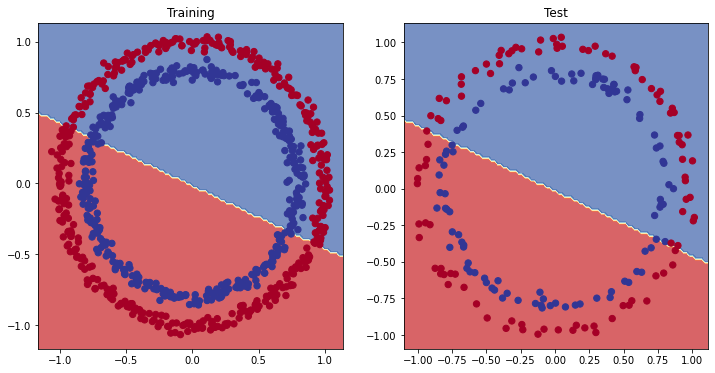

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Training')
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed ups where possible behind the scenes

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [ ]:
# Write a training and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Train for longer
epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forard pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the loss
    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

  # Print out what is happening
  if epoch % 100 == 0:
    print(f'Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69307, Acc: 51.25% | Test loss: 0.69614, Test acc: 46.50%
Epoch: 200 | Loss: 0.69301, Acc: 50.00% | Test loss: 0.69426, Test acc: 47.00%
Epoch: 300 | Loss: 0.69316, Acc: 49.50% | Test loss: 0.69367, Test acc: 51.50%
Epoch: 400 | Loss: 0.69306, Acc: 48.25% | Test loss: 0.69475, Test acc: 46.50%
Epoch: 500 | Loss: 0.69316, Acc: 50.50% | Test loss: 0.69598, Test acc: 47.00%
Epoch: 600 | Loss: 0.69335, Acc: 51.75% | Test loss: 0.69407, Test acc: 52.50%
Epoch: 700 | Loss: 0.69333, Acc: 51.00% | Test loss: 0.69555, Test acc: 49.00%
Epoch: 800 | Loss: 0.69325, Acc: 52.12% | Test loss: 0.69472, Test acc: 50.00%
Epoch: 900 | Loss: 0.69347, Acc: 50.25% | Test loss: 0.69353, Test acc: 49.50%


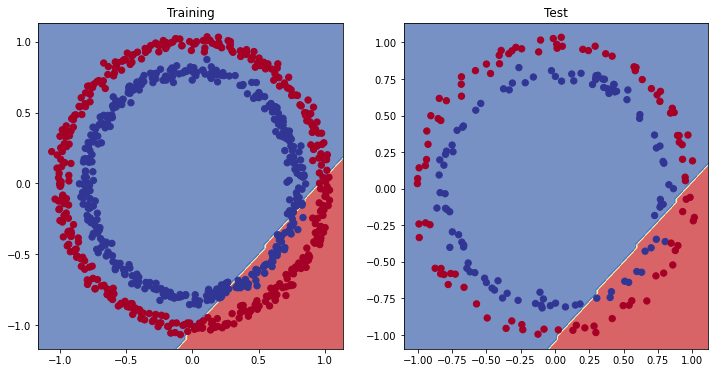

In [ ]:
# Plot the decision boundary
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Training')
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot a larger problem is to test out a smaller problem 

In [ ]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula, without epsilon

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]), tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# Create train and test split
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

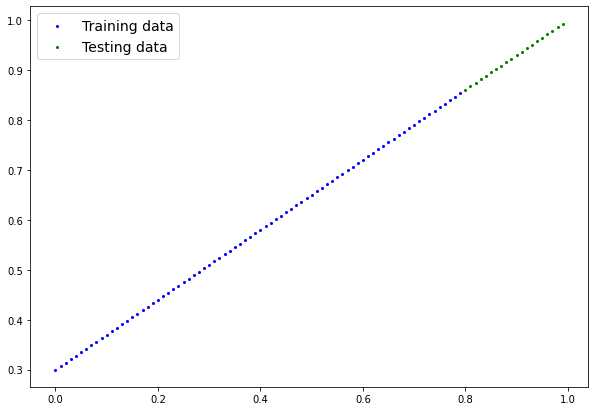

In [ ]:
plot_predictions(train_data = X_train_regression,
                 train_labels = y_train_regression,
                 test_data = X_test_regression,
                 test_labels = y_test_regression)

### 5.3 Adjust `model_1` to fit a straight line

In [ ]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.01)

In [ ]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
  model_2.train()
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out what's happening
  if epoch % 100 == 0:
    print(f'Epoch: {epoch} | Loss: {loss:.5f} | Test loss:{test_loss:.5f}')

Epoch: 0 | Loss: 0.75986 | Test loss:0.91103
Epoch: 100 | Loss: 0.02858 | Test loss:0.00081
Epoch: 200 | Loss: 0.02533 | Test loss:0.00209
Epoch: 300 | Loss: 0.02137 | Test loss:0.00305
Epoch: 400 | Loss: 0.01964 | Test loss:0.00341
Epoch: 500 | Loss: 0.01940 | Test loss:0.00387
Epoch: 600 | Loss: 0.01903 | Test loss:0.00379
Epoch: 700 | Loss: 0.01878 | Test loss:0.00381
Epoch: 800 | Loss: 0.01840 | Test loss:0.00329
Epoch: 900 | Loss: 0.01798 | Test loss:0.00360


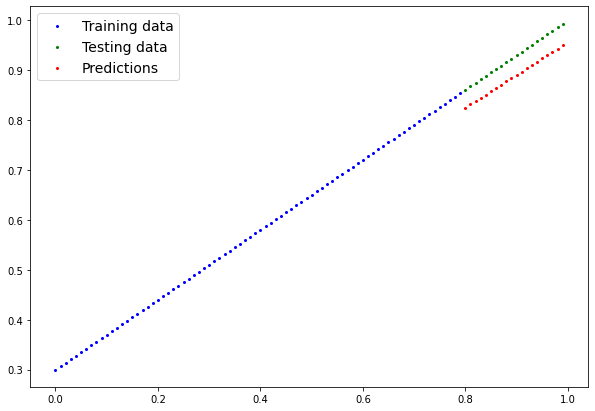

In [ ]:
# Turn on evaluation mode
model_2.eval()

# Make predictions
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data = X_train_regression.cpu(),
                 train_labels = y_train_regression.cpu(),
                 test_data = X_test_regression.cpu(),
                 test_labels = y_test_regression.cpu(),
                 predictions = y_preds.cpu())

## 6. The missing piece: non-linearity

What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?

## 6.1 Recreating non-linear data (red and blue circles)

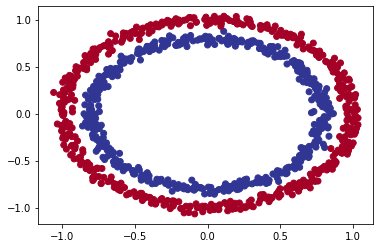

In [ ]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [ ]:
# Convert data to tensors and then to train and test splits
import torch 
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]), tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity

In [ ]:
# Build a model with non-linear activation functions
from torch import nn 
class CircleModelV2(nn.Module):
  def __init__(self) -> None:
      super().__init__()
      self.layer_1 = nn.Linear(in_features=2, out_features=10)
      self.layer_2 = nn.Linear(in_features=10, out_features=10)
      self.layer_3 = nn.Linear(in_features=10, out_features=1)
      self.relu = nn.ReLU()

  def forward(self, x):
    # Where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3
model_3.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0

In [ ]:
# Set up loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

### 6.4 Training a model with non-linearity

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  ### Training
  model_3.train()

  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
    
  # Print out what's happening
  if epoch % 100 == 0:
    print(f'Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}% ')

Epoch: 0 | Loss: 0.6929, Acc: 50.00% | Test Loss: 0.6932, Test Acc: 50.00% 
Epoch: 100 | Loss: 0.6912, Acc: 52.88% | Test Loss: 0.6910, Test Acc: 52.50% 
Epoch: 200 | Loss: 0.6898, Acc: 53.37% | Test Loss: 0.6894, Test Acc: 55.00% 
Epoch: 300 | Loss: 0.6879, Acc: 53.00% | Test Loss: 0.6872, Test Acc: 56.00% 
Epoch: 400 | Loss: 0.6852, Acc: 52.75% | Test Loss: 0.6841, Test Acc: 56.50% 
Epoch: 500 | Loss: 0.6810, Acc: 52.75% | Test Loss: 0.6794, Test Acc: 56.50% 
Epoch: 600 | Loss: 0.6751, Acc: 54.50% | Test Loss: 0.6729, Test Acc: 56.00% 
Epoch: 700 | Loss: 0.6666, Acc: 58.38% | Test Loss: 0.6632, Test Acc: 59.00% 
Epoch: 800 | Loss: 0.6516, Acc: 64.00% | Test Loss: 0.6476, Test Acc: 67.50% 
Epoch: 900 | Loss: 0.6236, Acc: 74.00% | Test Loss: 0.6215, Test Acc: 79.00% 


### 6.4 Evaluating a model trained with non-linear activation functions

In [ ]:
# Make predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

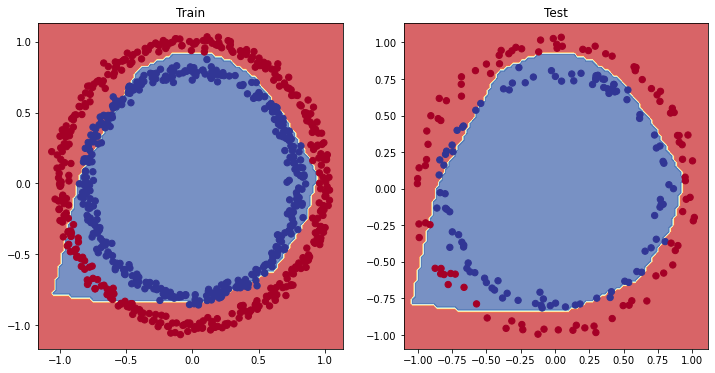

In [ ]:
# Plot decision boundaries
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_3, X_test, y_test)

In [ ]:
model_3.state_dict()

OrderedDict([('layer_1.weight', tensor([[ 0.6760,  0.8035],
                      [-0.1997,  0.7568],
                      [-0.1549,  0.1427],
                      [-0.9637,  0.2292],
                      [ 0.5717, -1.3426],
                      [ 0.6689,  0.1840],
                      [ 0.7970,  0.2595],
                      [ 0.3410, -0.0998],
                      [ 0.6555,  0.3186],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3761, -0.2008, -0.2872,  0.2803, -0.4513, -0.3364, -0.3300, -0.4252,
                      -0.1989, -0.6984])),
             ('layer_2.weight',
              tensor([[ 1.3081e-01, -3.7347e-01,  2.4414e-01, -4.3348e-02, -2.7270e-01,
                        1.0512e-01, -4.7109e-02,  2.5550e-01, -4.9248e-02, -9.9730e-02],
                      [ 7.9469e-01,  3.8277e-01,  1.3309e-01,  7.5399e-01,  9.7241e-01,
                        2.6996e-01,  6.2185e-01,  5.6581e-02,  5.3486e-01, -1.9274e-01],
      

### 7. Replicating non-linear activation functions

Neural networks, rather than us telling the model what to learn, we give it the tools to discover partterns in data and it tries to figure out the patters on its own.

And these tools are linear and non-linear functions 

In [ ]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype = torch.float32)
A.dtype

torch.float32

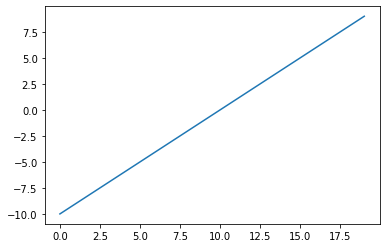

In [ ]:
# Visualize the tensor
plt.plot(A);

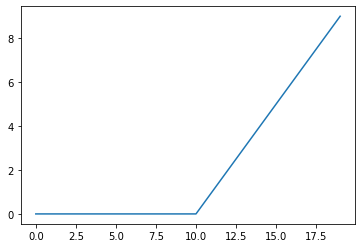

In [ ]:
plt.plot(torch.relu(A));

In [ ]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

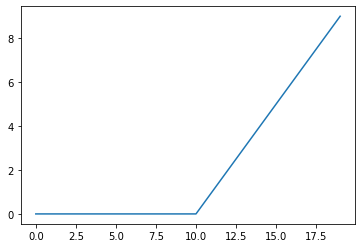

In [ ]:
# Plot ReLU activation function
plt.plot(relu(A));

In [ ]:
# Now let us do the same for the Sigmoid
def sigmoid(x: torch.Tensor) -> torch.Tensor:
  return 1/(1 + torch.exp(-x))

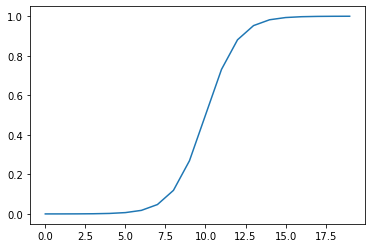

In [ ]:
plt.plot(torch.sigmoid(A));

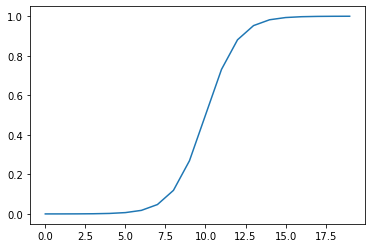

In [ ]:
plt.plot(sigmoid(A));

## 8. Putting it all together with a multiclass classification problem

* Binary classification = one thing or another (cat vs. dog, spam vs. not spam, fraud vs. not fraud)
* Multi-class classification = more than one thing or another (cat vs. dog vs. chicken)

### 8.1 Creating a toy multi-class dataset

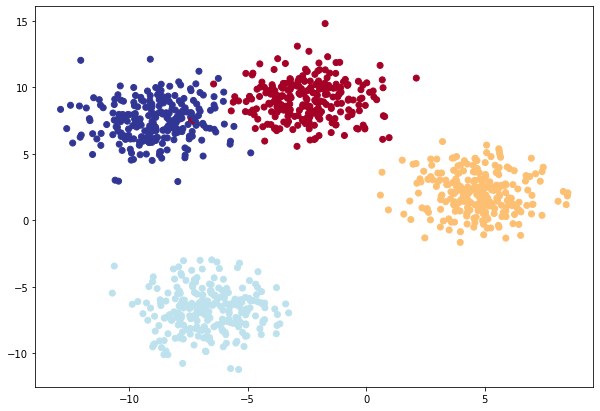

In [ ]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multiclass data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                       y_blob,
                                                                       test_size=0.2,
                                                                       random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:,0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 8.2 Building a multi-class classification model in PyTorch

In [ ]:
# Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# Build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    '''Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of output features/classes
      hidden units (int): Number of hidden units between layers, default is 8
    
    Returns:
    '''
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )
  
  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and optimizer for a multi-class model

In [ ]:
# Create a loss function for multi-class classifiction - loss function measures how wrong our model's predictions are
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer - optimizer updates our model parameters to try and reduce the loss
optimizer = torch.optim.SGD(params=model_4.parameters(),
                         lr=0.1)


### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

Logits (raw output of the model) -> Pred Probs (use `torch.softmax()` -> Pred Labels (take the argmax)

In [ ]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [ ]:
# Convert our model's logit outputs to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [ ]:
torch.argmax(y_pred_probs[1])


tensor(0, device='cuda:0')

In [ ]:
# Convert our model's probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

### 8.5 Create a training loop and testing loop for a multi-class PyTorch model

In [ ]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  ### Training
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
    
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)
    
  # Print out what is happening
  if epoch % 10 ==0 :
    print(f'Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%')


Epoch: 0 | Loss: 1.0636, Acc: 54.62% | Test loss: 1.0039, Test acc: 55.00%
Epoch: 10 | Loss: 0.6210, Acc: 97.25% | Test loss: 0.6367, Test acc: 98.00%
Epoch: 20 | Loss: 0.4061, Acc: 98.75% | Test loss: 0.4104, Test acc: 100.00%
Epoch: 30 | Loss: 0.2362, Acc: 99.12% | Test loss: 0.2268, Test acc: 99.50%
Epoch: 40 | Loss: 0.1044, Acc: 99.25% | Test loss: 0.0949, Test acc: 99.50%
Epoch: 50 | Loss: 0.0640, Acc: 99.25% | Test loss: 0.0563, Test acc: 99.50%
Epoch: 60 | Loss: 0.0497, Acc: 99.25% | Test loss: 0.0419, Test acc: 99.50%
Epoch: 70 | Loss: 0.0424, Acc: 99.25% | Test loss: 0.0343, Test acc: 99.50%
Epoch: 80 | Loss: 0.0380, Acc: 99.25% | Test loss: 0.0295, Test acc: 99.50%
Epoch: 90 | Loss: 0.0350, Acc: 99.25% | Test loss: 0.0264, Test acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [ ]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-0.6257,  6.0063, -7.6488, -8.4666],
        [-2.1813, -6.3889, -3.7303,  3.1376],
        [-3.4241, -3.9088,  3.1701, -2.6211],
        [-1.1539,  4.2110, -3.8565, -4.8926],
        [ 3.7713, -1.3379, -9.1623, -6.9665],
        [-2.8284, -7.5936, -4.3072,  3.8118],
        [-3.0427, -3.3442,  2.8070, -2.1454],
        [ 3.3902, -4.0445, -6.9149, -3.5610],
        [-4.3793, -5.0066,  3.8291, -3.3930],
        [ 3.5159, -3.0320, -7.5575, -4.7203]], device='cuda:0')

In [ ]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3158e-03, 9.9868e-01, 1.1725e-06, 5.1754e-07],
        [4.8691e-03, 7.2458e-05, 1.0344e-03, 9.9402e-01],
        [1.3611e-03, 8.3833e-04, 9.9476e-01, 3.0383e-03],
        [4.6540e-03, 9.9492e-01, 3.1196e-04, 1.1070e-04],
        [9.9397e-01, 6.0044e-03, 2.4010e-06, 2.1578e-05],
        [1.3046e-03, 1.1117e-05, 2.9733e-04, 9.9839e-01],
        [2.8462e-03, 2.1055e-03, 9.8807e-01, 6.9819e-03],
        [9.9842e-01, 5.8947e-04, 3.3409e-05, 9.5600e-04],
        [2.7205e-04, 1.4528e-04, 9.9885e-01, 7.2945e-04],
        [9.9829e-01, 1.4306e-03, 1.5493e-05, 2.6444e-04]], device='cuda:0')

In [ ]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

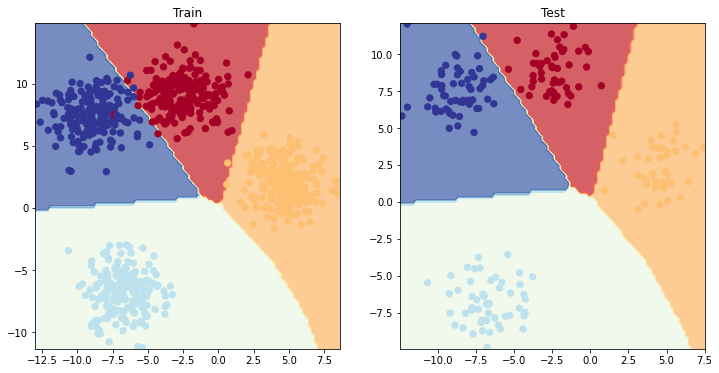

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. A few more classification metrics...

* Accuracy - out of a 100 samples, how many does our model gets right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 5.1 MB/s 


In [ ]:
from torchmetrics import Accuracy

# Set up metric
torchmetric_accuracy = Accuracy().to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')